<a href="https://colab.research.google.com/github/Atit-Bashyal/Merkel_1/blob/main/var_%26_VAR_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import pandas as pd
import os
import random
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
register_matplotlib_converters()

from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train.index, train[name], label='train')
    plt.plot(test.index, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

In [ ]:
merkel_1 = pd.read_csv('/content/drive/MyDrive/Wind_turbines/Meckel_1.csv',parse_dates=[0],index_col=0)
merkel_4 = pd.read_csv('/content/drive/MyDrive/Wind_turbines/Meckel_4.csv',parse_dates=[0],index_col=0)
rens_3 = pd.read_csv('/content/drive/MyDrive/Wind_turbines/Reinsfeld_3.csv',parse_dates=[0],index_col=0)

In [ ]:
def cycle_encode(data, cols):
    
    for col in cols:
        
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        
    return data

In [ ]:
merkel_1 = merkel_1[['power','wind_speed','wind_direction']]
merkel_1_p = merkel_1.reset_index()
merkel_1_p

,datetime,power,wind_speed,wind_direction
0,2019-02-13 12:30:00,-0.003,0.8,233.0
1,2019-02-13 12:45:00,-0.003,0.8,358.0
2,2019-02-13 13:00:00,-0.003,0.9,319.0
3,2019-02-13 13:15:00,-0.003,0.8,290.0
4,2019-02-13 13:30:00,-0.003,0.8,270.0
...,...,...,...,...
65235,2020-12-21 13:15:00,555.373,7.4,182.0
65236,2020-12-21 13:30:00,787.080,8.0,183.0
65237,2020-12-21 13:45:00,567.633,7.3,175.0
65238,2020-12-21 14:00:00,502.050,7.2,171.0


In [ ]:
merkel_1_p['month'] = merkel_1_p.datetime.dt.month
merkel_1_p['day'] = merkel_1_p.datetime.dt.dayofweek
merkel_1_p['hour'] = merkel_1_p.datetime.dt.hour

merkel_1_p = cycle_encode(merkel_1_p, ['month','day','hour'])
merkel_1_p.drop(['month','day','hour'], axis=1, inplace=True)
merkel_1_p.set_index('datetime', inplace=True)

print(merkel_1_p.shape)
merkel_1_p.head()

(65240, 9)


,power,wind_speed,wind_direction,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
datetime,,,,,,,,,
2019-02-13 12:30:00,-0.003,0.8,233.0,0.866025,0.5,0.866025,-0.5,-0.136167,-0.990686
2019-02-13 12:45:00,-0.003,0.8,358.0,0.866025,0.5,0.866025,-0.5,-0.136167,-0.990686
2019-02-13 13:00:00,-0.003,0.9,319.0,0.866025,0.5,0.866025,-0.5,-0.398401,-0.917211
2019-02-13 13:15:00,-0.003,0.8,290.0,0.866025,0.5,0.866025,-0.5,-0.398401,-0.917211
2019-02-13 13:30:00,-0.003,0.8,270.0,0.866025,0.5,0.866025,-0.5,-0.398401,-0.917211


In [ ]:
train, test = train_test_split(merkel_1_p, shuffle=False, train_size=0.5)

print(train.shape, test.shape)

(32620, 9) (32620, 9)


In [ ]:
test

,power,wind_speed,wind_direction,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
datetime,,,,,,,,,
2020-01-18 01:30:00,225.685,6.3,239.0,5.000000e-01,0.866025,-0.866025,0.5,0.269797,0.962917
2020-01-18 01:45:00,218.218,5.9,232.0,5.000000e-01,0.866025,-0.866025,0.5,0.269797,0.962917
2020-01-18 02:00:00,167.534,4.9,235.0,5.000000e-01,0.866025,-0.866025,0.5,0.519584,0.854419
2020-01-18 02:15:00,118.245,4.4,242.0,5.000000e-01,0.866025,-0.866025,0.5,0.519584,0.854419
2020-01-18 02:30:00,176.052,4.9,228.0,5.000000e-01,0.866025,-0.866025,0.5,0.519584,0.854419
...,...,...,...,...,...,...,...,...,...
2020-12-21 13:15:00,555.373,7.4,182.0,-2.449294e-16,1.000000,0.000000,1.0,-0.398401,-0.917211
2020-12-21 13:30:00,787.080,8.0,183.0,-2.449294e-16,1.000000,0.000000,1.0,-0.398401,-0.917211
2020-12-21 13:45:00,567.633,7.3,175.0,-2.449294e-16,1.000000,0.000000,1.0,-0.398401,-0.917211


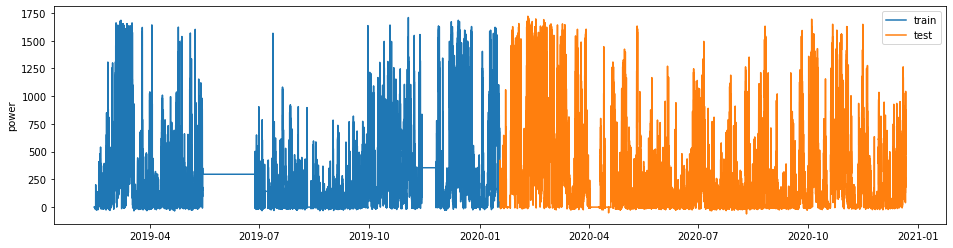

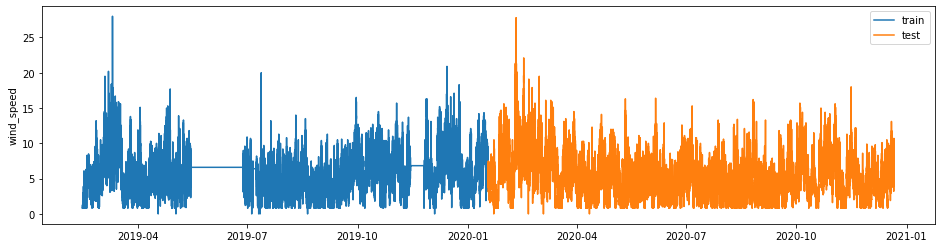

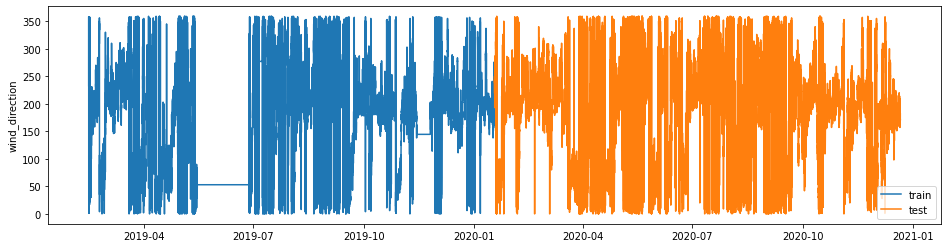

In [ ]:
### PLOT ORIGINAL SERIES ###

for col in merkel_1.columns:
    plot_sensor(col)

In [ ]:
### OPERATE DIFFERENTIATION ###

period = 4*24

df_diff = merkel_1.diff(period).dropna()
df_external = merkel_1_p.iloc[period:].copy()

In [ ]:
### SPLIT DIFFERENTIAL DATA IN TRAIN AND TEST ###

train_diff = df_diff.iloc[:len(train)-period,:].copy()
test_diff = df_diff.iloc[len(train)-period:,:].copy()

train_init = merkel_1.iloc[:len(train)-period,:].copy()
test_init = merkel_1.iloc[len(train)-period:-period,:].copy()

train_ext = merkel_1_p.iloc[:len(train)-period,:].copy()
test_ext = merkel_1_p.iloc[len(train)-period:,:].copy()

print(train_diff.shape, train_init.shape, train_ext.shape)
print(test_diff.shape, test_init.shape, test_ext.shape)

(32524, 3) (32524, 3) (32524, 9)
(32620, 3) (32620, 3) (32620, 9)


In [ ]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,50):
    model = VAR(endog=train_diff.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 49 BEST AIC: 18.970346349620694


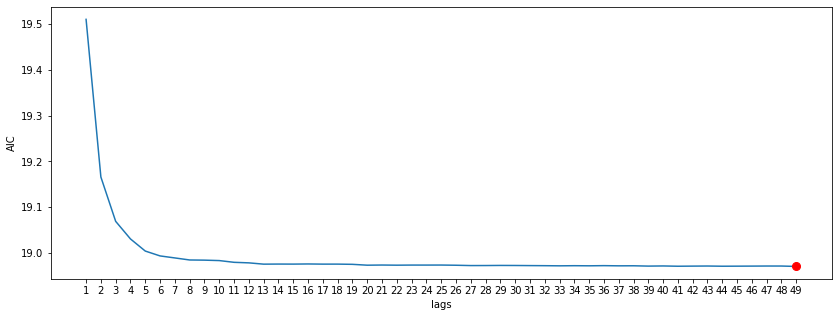

In [ ]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,50))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [ ]:
var = VAR(endog=train_diff.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

18.970346349620694

In [ ]:

### UTILITY FUNCTION FOR RETRIVE VAR PREDICTIONS ###

def retrive_prediction(prior, prior_init, steps):
    
    pred = var_result.forecast(np.asarray(prior), steps=steps)
    init = prior_init.tail(period).values
    
    if steps > period:
        id_period = list(range(period))*(steps//period)
        id_period = id_period + list(range(steps-len(id_period)))
    else:
        id_period = list(range(steps))
    
    final_pred = np.zeros((steps, prior.shape[1]))
    for j, (i,p) in enumerate(zip(id_period, pred)):
        final_pred[j] = init[i]+p
        init[i] = init[i]+p    
        
    return final_pred

In [ ]:
date = '2020-01-18 01:30:00'
forward = 100
date_range = pd.date_range(date, periods=forward+1, freq='H', closed='right')

final_pred = retrive_prediction(df_diff.loc[:date], merkel_1.loc[:date], steps = forward)
final_true = merkel_1.loc[date_range]

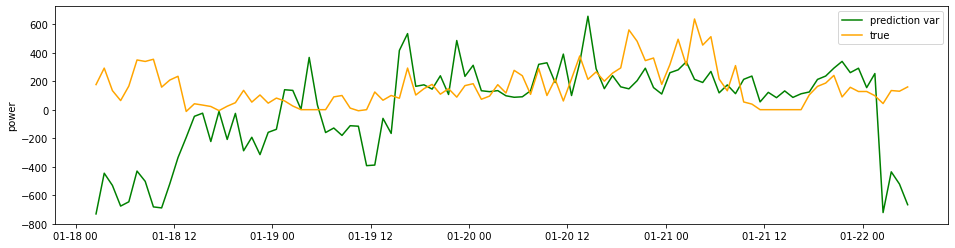

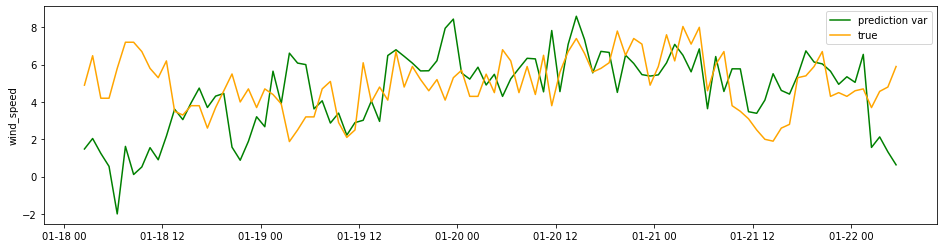

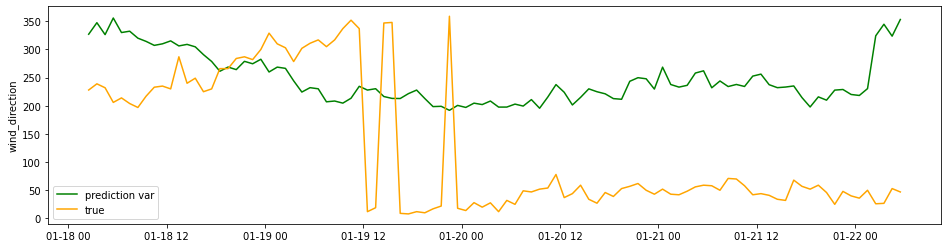

In [ ]:
for i,col in enumerate(merkel_1.columns):

    plt.figure(figsize=(16,4))
    plt.plot(date_range, final_pred[:,i], c='green', label='prediction var')
    plt.plot(date_range, final_true[col].values, c='orange', label='true')
    plt.ylabel(col); plt.legend()
    plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
NN_df = merkel_1[['wind_speed','power']]

In [ ]:
train_df,test_df = NN_df[1:32620], NN_df[32620:] 

In [ ]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [ ]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 4*24*10
n_future = 4*24 
n_features = 2

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
# Sequence to Sequence Model with one encoder layer and one decoder layer.

# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 960, 2)]     0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 100), (None, 41200       input_4[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 96, 100)      0           lstm_6[0][0]                     
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 96, 100)      80400       repeat_vector_1[0][0]            
                                                                 lstm_6[0][1]               

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=3,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

Epoch 1/3
987/987 [==============================] - 732s 739ms/step - loss: 0.0179 - val_loss: 0.0191
Epoch 2/3
987/987 [==============================] - 796s 806ms/step - loss: 0.0169 - val_loss: 0.0195
Epoch 3/3
987/987 [==============================] - 794s 805ms/step - loss: 0.0167 - val_loss: 0.0194


In [ ]:
pred_e1d1=model_e1d1.predict(X_test)

In [ ]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [ ]:
df_final =NN_df[pred_e1d1.shape[0]*-1:]

In [ ]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Day ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
  print()
  print()

wind_speed
Day  1 :
MAE-E1D1 :  14.830615698412693, Day  2 :
MAE-E1D1 :  15.953415197872248, Day  3 :
MAE-E1D1 :  16.950024102098745, Day  4 :
MAE-E1D1 :  17.905210420930143, Day  5 :
MAE-E1D1 :  18.70796144014063, 

power
Day  1 :
MAE-E1D1 :  125333.81604112, Day  2 :
MAE-E1D1 :  136147.4284479931, Day  3 :
MAE-E1D1 :  146155.27266004233, Day  4 :
MAE-E1D1 :  155742.8845440205, Day  5 :
MAE-E1D1 :  164063.6075985257, 

